## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import List, Optional, Tuple
import pathlib
import math
from functools import reduce
import time

import torch
from torch import nn
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import pandas as pd

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Nerual ODE model definition

In [ ]:
def divergence_approx(f, y, e):
    """Not suitable for 1-dimensional problem"""
    e_dzdx = torch.autograd.grad(f, y, e, create_graph=True)[0]
    e_dzdx_e = e_dzdx * e
    approx_tr_dzdx = e_dzdx_e.view(y.shape[0], -1).sum(dim=1)
    return approx_tr_dzdx

def divergence_bf(dx, y, **unused_kwargs):
    """Computationally costly, but accurate"""
    sum_diag = 0.
    for i in range(y.shape[1]):
        sum_diag += torch.autograd.grad(dx[:, i].sum(), y, create_graph=True)[0].contiguous()[:, i].contiguous()
    return sum_diag.contiguous()


class ODEModel(nn.Module):
    def __init__(self, hidden_dims=8, num_freqs=4, atol=1e-9, hidden_activation=nn.Tanh):
        super(ODEModel, self).__init__()
        self.num_freqs = num_freqs
        self.in_size = 4 * self.num_freqs + 2 
        self.atol = atol

        self.net = nn.Sequential(
            nn.Linear(self.in_size, hidden_dims),
            hidden_activation(),
            nn.Linear(hidden_dims, hidden_dims),
            hidden_activation(),
            nn.Linear(hidden_dims, hidden_dims),
            hidden_activation(),
            nn.Linear(hidden_dims, 1)
        )
        self.noise = None # must be constant when ODE is solved
        self.latent_distribution = torch.distributions.normal.Normal(0, 1)

    def before_odesolve(self):
        """Prepare model for one pass through an ODE solver"""
        self.noise = None

    def forward(self, t, location_and_logpz):
        x, logpz = location_and_logpz

        if self.noise is None:
          self.noise = torch.randn_like(x)

        t = t.view(1,1).expand(x.shape[0], -1)
        
        with torch.set_grad_enabled(True):
          x.requires_grad_(True)
          xx = torch.cat([t, x], dim=1)
          xx = self.add_positional_encoding(xx)
          dx = self.net(xx)
          divergence = divergence_bf(dx, x, e=self.noise)

        return dx, -divergence

    def add_positional_encoding(self, xx):
        batch_size, features = xx.shape
        
        cosine_vals = torch.zeros(batch_size, self.num_freqs * features, device=xx.device)
        sine_vals = torch.zeros(batch_size, self.num_freqs * features, device=xx.device)
        
        for i in range(self.num_freqs):
          cosine_vals[:, i*features:(i+1)*features] = torch.cos(xx * 2 ** i)
          sine_vals[:, i*features:(i+1)*features] = torch.sin(xx * 2 ** i)
        
        xx = torch.cat([xx, cosine_vals, sine_vals], dim=1)
        
        return xx

    def latent_density(self, x):
      return torch.exp(self.latent_distribution.log_prob(x))

    def latent_log_prob(self, x):
      return self.latent_distribution.log_prob(x)

def train_step(x, model, optimizer):
    optimizer.zero_grad()

    t = torch.linspace(0, 1, 2)
    x = (x.view(-1, 1), torch.zeros(x.shape, device=x.device))
    model.before_odesolve()
    z, logpz = odeint(model, x, t, atol=model.atol)
    
    z = z[-1]
    logpz = logpz[-1]

    expected_logpz = model.latent_log_prob(z)

    loss = -torch.mean(expected_logpz - logpz)

    loss.backward()
    optimizer.step()
    return loss

## Prepare training data

In [ ]:
def safe_prob(dist, x: float):
    try:
      return torch.exp(dist.log_prob(x)).item()
    except ValueError: # Outside of distribution support
      return 0

class BetaDistributionDataset(torch.utils.data.Dataset):
    def __init__(self, concentration1, concentration0, num_samples=512):
        self.dist = torch.distributions.beta.Beta(concentration1, concentration0)
        self.num_samples = num_samples

    def __getitem__(self, _idx):
        return self.dist.sample()

    def __len__(self):
      return self.num_samples

    def log_prob(self, x):
      return self.dist.log_prob(x)

    def prob(self, x) -> np.array:
      if isinstance(x, float) or isinstance(x, int):
        x = [x]
      if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x)

      result = []
      for xx in x:
        result.append(safe_prob(self.dist, xx))

      return np.array(result)

class BetaSumDistributionDataset(torch.utils.data.Dataset):
    def __init__(self, concentrations1: List[float], concentrations0: List[float], shifts: List[float], num_samples=512):
        self.dists = [torch.distributions.beta.Beta(c1, c0) for c1, c0 in zip(concentrations1, concentrations0)]
        self.shifts = shifts
        self.num_samples = num_samples

    def __getitem__(self, _idx):
        idx = np.random.randint(0, len(self.dists))
        dist = self.dists[idx]
        shift = self.shifts[idx]
        return dist.sample() + shift

    def __len__(self):
        return self.num_samples

    def prob(self, x) -> np.array:
        if isinstance(x, float) or isinstance(x, int):
          x = [x]
        if not isinstance(x, torch.Tensor):
          x = torch.Tensor(x)

        result = []
        for xx in x:
          pdf_xx = 0
          for dist, shift in zip(self.dists, self.shifts):
            pdf_xx += safe_prob(dist, xx - shift)
          result.append(pdf_xx)

        return np.array(result) / len(self.dists)


class NormalDistributionDataset(torch.utils.data.Dataset):
    def __init__(self, mean, std, num_samples=512):
        self.dist = torch.distributions.normal.Normal(mean, std)
        self.num_samples = num_samples

    def __getitem__(self, _idx):
        return self.dist.sample()

    def __len__(self):
      return self.num_samples

    def log_prob(self, x):
      return self.dist.log_prob(x)

    def prob(self, x) -> np.array:
      if isinstance(x, float) or isinstance(x, int):
        x = [x]
      if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x)

      result = []
      for xx in x:
        result.append(safe_prob(self.dist, xx))

      return np.array(result)

class BernoulliDataset(torch.utils.data.Dataset):
    def __init__(self, p, snum_samples=512):
        self.dist = torch.distributions.bernoulli.Bernoulli(p)
        self.num_samples = num_samples

    def __getitem__(self, _idx):
        return self.dist.sample()

    def __len__(self):
      return self.num_samples

    def prob(self, x) -> np.array:
      if isinstance(x, float) or isinstance(x, int):
        x = [x]
      if not isinstance(x, torch.Tensor):
        x = torch.Tensor(x)

      result = []
      for xx in x:
        result.append(safe_prob(self.dist, xx))

      return np.array(result)

## Visualisation

In [ ]:
T_STEPS = 64
X_STEPS = 128
LOW = -2
HIGH = 2

def plot_stream(ax, model, color="black"):
    x = torch.linspace(LOW, HIGH, X_STEPS, device=device).view(-1, 1)
    t = torch.linspace(0, 1, T_STEPS, device=device)
    dt = 1 / T_STEPS

    dxdt = []
    for t_step in t:
      model.before_odesolve()
      with torch.no_grad():
        one_dxdt, _logp = model(t_step, (x, torch.zeros(x.shape, device=device)))

      one_dxdt = one_dxdt.cpu().detach().numpy().squeeze()
      dx = one_dxdt * dt
      out = np.stack([dx, np.ones(one_dxdt.shape) * dt], axis=1)
      dxdt.append(out)

    dxdt = np.stack(dxdt, axis=0)

    t = t.cpu().numpy()
    x = x.detach().cpu().numpy()
    ax.streamplot(x.squeeze(), t, -dxdt[:, :, 0].squeeze(), -dxdt[:, :, 1].squeeze(), color=color)

def get_pdf(model, end_t: float):
    x = torch.linspace(LOW, HIGH, X_STEPS, device=device).view(-1, 1)
    if end_t >= 1.0:
      return x.cpu().numpy().squeeze(), model.latent_density(x).cpu().numpy().squeeze()
    
    with torch.no_grad():
      model.before_odesolve()
        
      z, _ = odeint(model, (x, torch.zeros(x.shape, device=device)), torch.Tensor([end_t, 1.0]).to(device=device), atol=model.atol)
      z = z[-1]
      logpz = model.latent_log_prob(z)

      model.before_odesolve()
      xx, logpx = odeint(model, (z, logpz), torch.Tensor([1.0, end_t]).to(device=device)) # Solve backward in time

    x = x.cpu().numpy().squeeze()
    densities = np.exp(logpx.cpu().numpy())[-1].squeeze()
    return x, densities

def plot_density(ax, model):
    t = np.linspace(0, 1, T_STEPS)

    densities = []
    for tt in t:
      x, pdf = get_pdf(model, tt)
      pdf = np.clip(pdf, 0, 2)
      densities.append(pdf)
  
    densities = np.stack(densities)
    pcm = ax.pcolormesh(x, t, densities)
    # plt.colorbar(pcm, ax=ax)

    ax.set_xlim(LOW, HIGH)
    ax.set_ylim(0, 1.0)

    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))

def plot_pdf(ax, model=None, dataset=None, **kwargs):
    assert model is not None or dataset is not None 
    
    if model is not None:
      x, y = get_pdf(model, 0.0)
      y = y.squeeze()
    if dataset is not None:
      x = np.linspace(LOW, HIGH, X_STEPS)
      y = dataset.prob(x)

    ax.plot(x, y, **kwargs)

def plot_latent_pdf(ax, model: ODEModel, **kwargs):
    x = torch.linspace(LOW, HIGH, X_STEPS, device=device)
    y = model.latent_distribution.log_prob(x)
    y = torch.exp(y).cpu().numpy()
    x = x.squeeze().cpu().numpy()

    ax.plot(x, y, **kwargs)

def visualise_model(model: ODEModel, 
                    dataset,
                    gs=None,
                    fig=None,
                    loss: Optional[float]=None):

    if gs is None:
      ax1 = plt.subplot(1, 3, 1)
      ax2 = plt.subplot(1, 3, 2)
      ax3 = plt.subplot(1, 3, 3)
    else:
      ax1 = fig.add_subplot(gs[0])
      ax2 = fig.add_subplot(gs[1])
      ax3 = fig.add_subplot(gs[2])

    ax1.set_title(f'Latent space')
    ax1.set_ylabel('pdf')
    plot_latent_pdf(ax1, model)

    ax2.set_title(f'Density flow')
    ax2.set_ylabel('t')

    plot_density(ax2, model)
    plot_stream(ax2, model,color="white")

    if loss is None:
      ax3.set_title(f'Target space')
    else:
      ax3.set_title(f'Target space (loss={loss:.4f})')
    ax3.set_xlabel('x')
    ax3.set_ylabel('pdf')
    plot_pdf(ax3, model=model, label="predicted")
    plot_pdf(ax3, dataset=dataset, label="real")
    ax3.legend()

## Training

In [ ]:
def train_model(dataset, batch_size, lr=1e-3, hidden_dims=8, num_freqs=4, atol=1e-9, report=False, hidden_activation=nn.Tanh) -> ODEModel:
  model = ODEModel(hidden_dims=hidden_dims, num_freqs=num_freqs, atol=atol, hidden_activation=hidden_activation).to(device=device)
  generator_optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

  for i, x_batch in enumerate(tqdm(dataloader)):
    x_batch = x_batch.to(device)
    loss = train_step(x_batch, model, generator_optimizer)
    if report and i % 64 == 0:
      plt.clf()
      plt.figure(figsize=(21, 6))
      visualise_model(model, dataset, loss=loss)
      plt.show()

  return model, loss.item()

def train_and_plot(steps, batch_size, atol, lr, dim, num_freqs, activation):
  num_samples = steps * batch_size

  datasets = [
            BetaSumDistributionDataset([1], [1], shifts=[0.75], num_samples=num_samples),
            BetaSumDistributionDataset([1, 3, 5], [1, 3, 2], shifts=[-2, 0, 0.5], num_samples=num_samples),
            BetaSumDistributionDataset([1, 5, 3, 5], [1, 1, 3, 2], shifts=[-2, -1, 0, 0.5], num_samples=num_samples),
            BetaSumDistributionDataset([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5], shifts=[-2, -1, -0.1, 1], num_samples=num_samples),
            ]

  plt.clf()
  fig = plt.figure(figsize=(5 * len(datasets), 12))
  gs = matplotlib.gridspec.GridSpec(nrows=3, ncols=len(datasets), height_ratios=[2, 4, 3])

  times = []
  for i, dataset in enumerate(datasets):
    start_time = time.time()
    model, loss = train_model(dataset, hidden_dims=dim, num_freqs=num_freqs, batch_size=batch_size, lr=lr, atol=atol, report=False, hidden_activation=activation)
    times.append(time.time() - start_time)
    visualise_model(model, dataset, gs=[gs[0,i], gs[1,i], gs[2,i]], fig=fig, loss=loss)

  t = np.sum(times)
  print(f"Training time: {t:.0f}s ({t/60:.2f}min)")

  plt.show()

#### Examples

##### Working setup

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y

Training time: 543s (9.05min)


<Figure size 432x288 with 0 Axes>

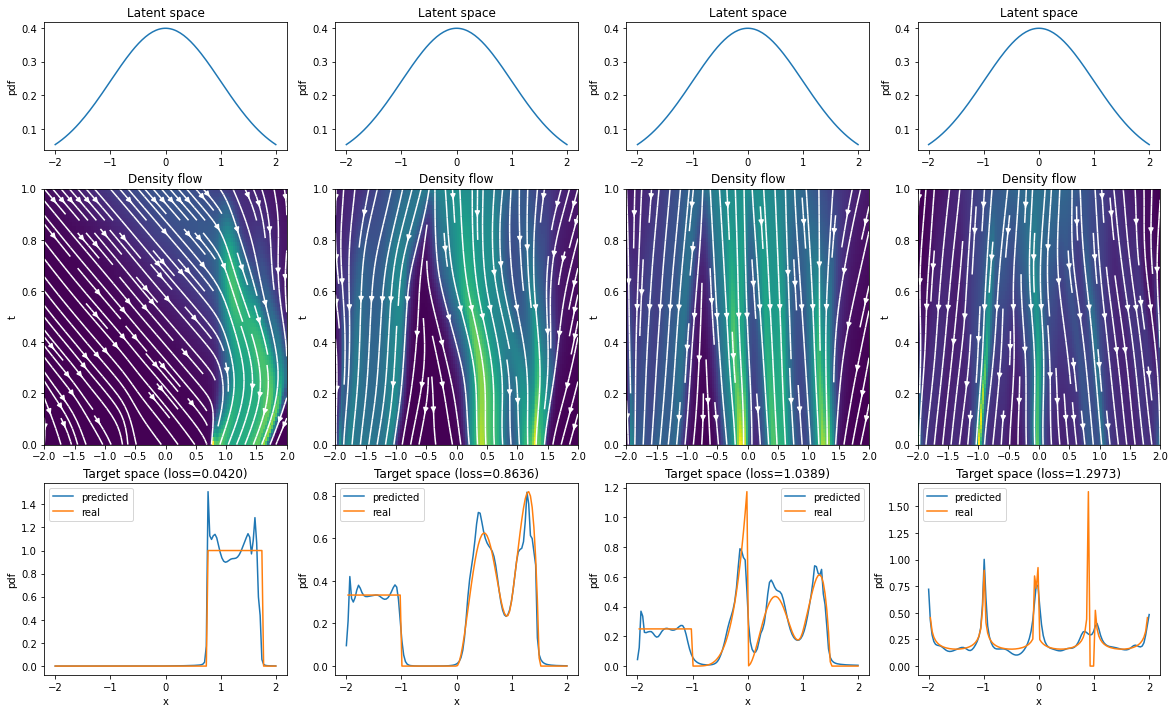

In [ ]:
train_and_plot(steps=256, batch_size=256, atol=1e-4, lr=0.01, dim=8, num_freqs=4, activation=nn.Tanh)

##### We can change the quality of ODE solution

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y

Training time: 2947s (49.12min)


<Figure size 432x288 with 0 Axes>

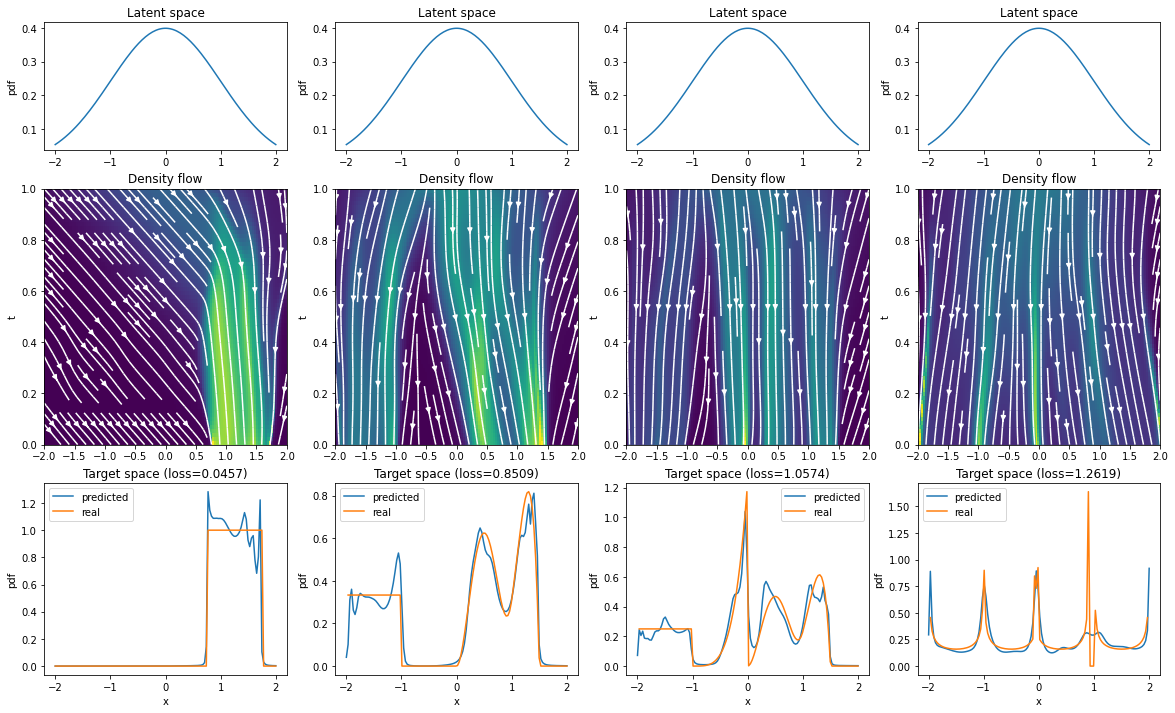

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y

Training time: 244s (4.07min)


<Figure size 432x288 with 0 Axes>

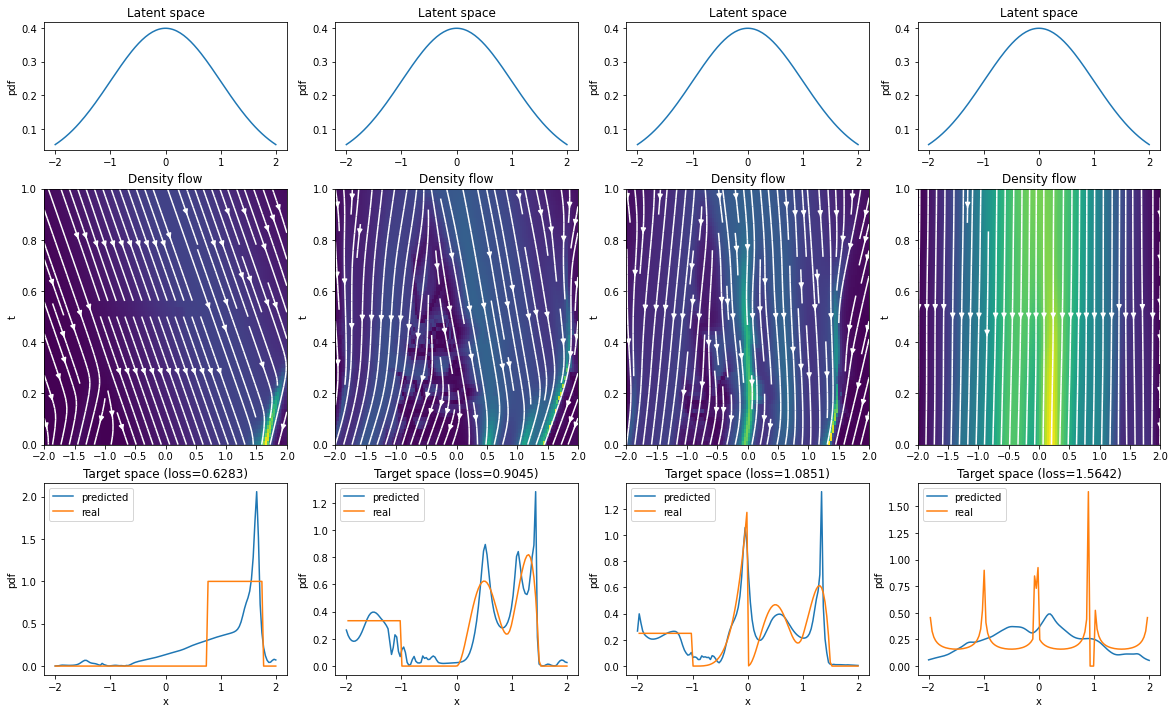

In [ ]:
train_and_plot(steps=256, batch_size=256, atol=1e-9, lr=0.01, dim=8, num_freqs=4, activation=nn.Tanh)

train_and_plot(steps=256, batch_size=256, atol=1e-1, lr=0.01, dim=8, num_freqs=4, activation=nn.Tanh)

##### Let's remove positional encoding

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y

Training time: 142s (2.37min)


<Figure size 432x288 with 0 Axes>

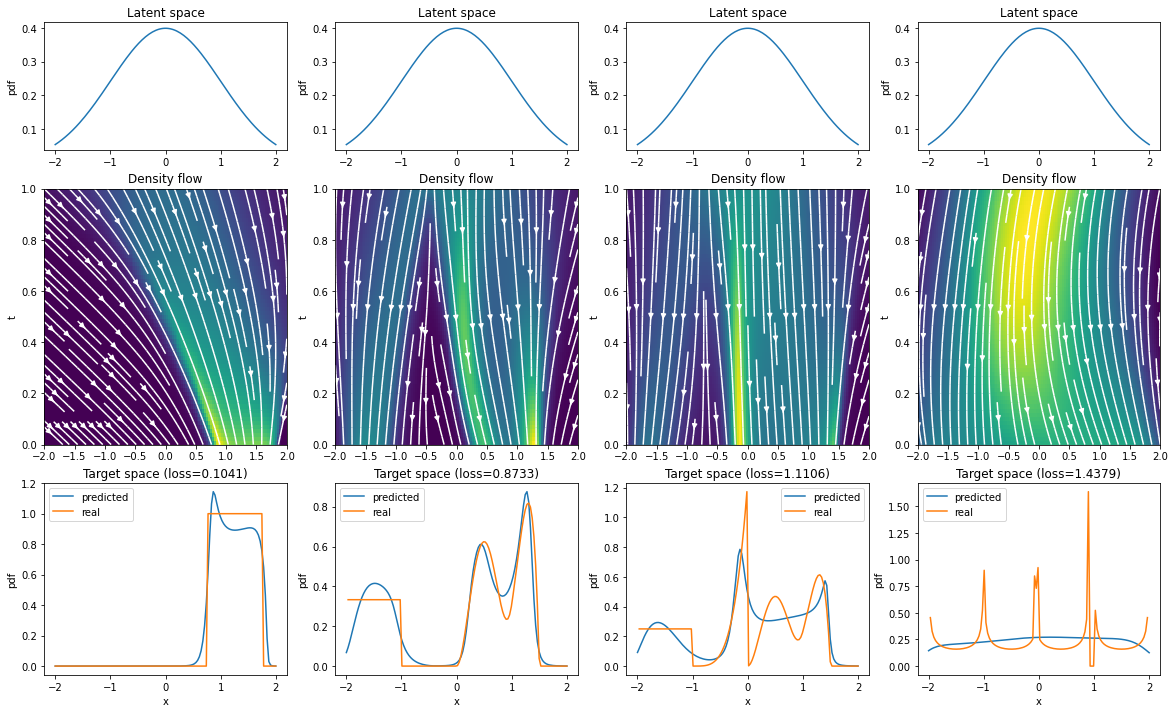

In [ ]:
train_and_plot(steps=256, batch_size=256, atol=1e-4, lr=0.01, dim=8, num_freqs=0, activation=nn.Tanh)

##### Let's change the hidden activation

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
100%|██████████| 256/256 [03:58<00:00,  1.07it/s]


Training time: 1329s (22.16min)


<Figure size 432x288 with 0 Axes>

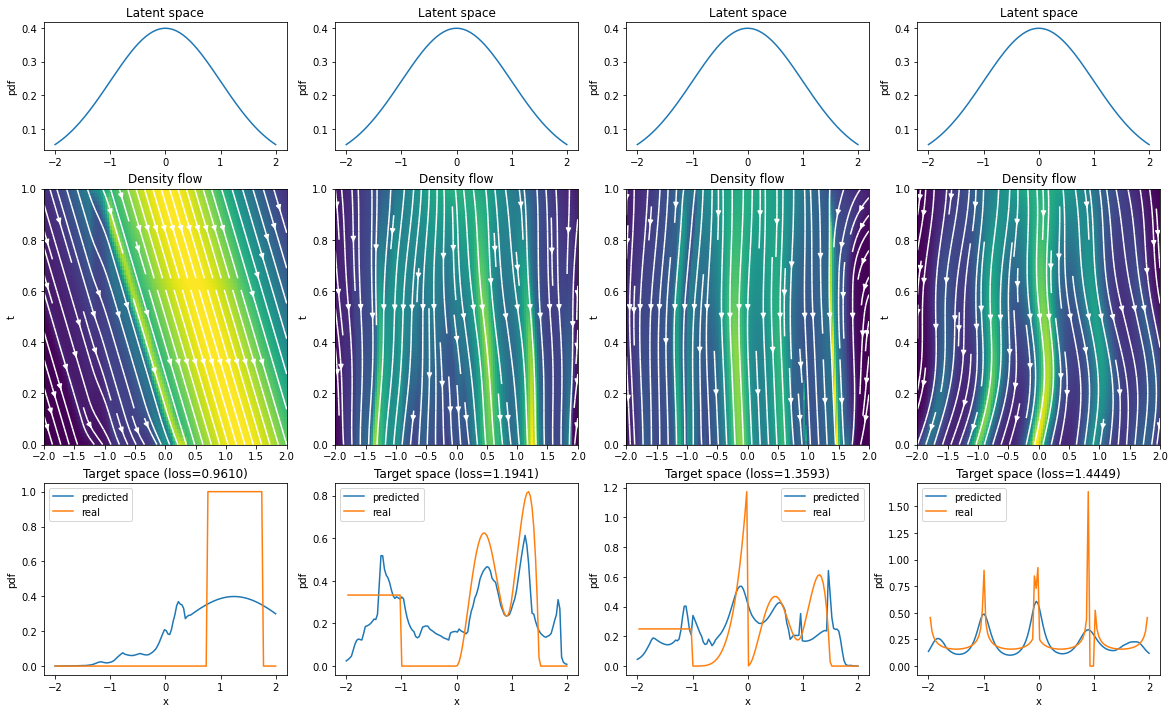

In [ ]:
train_and_plot(steps=256, batch_size=256, atol=1e-4, lr=0.01, dim=8, num_freqs=4, activation=nn.ReLU)

#### Grid search

In [ ]:
def update_results(losses, num_freqs, atol, batch_size, dim, lr, config_name, device, folder_path, times, steps):
  sheet_name = 'ode_results.csv'
  new_row_df = pd.DataFrame({
          'config_name': [config_name],
          'losses': [losses],
          'loss mean': [np.mean(losses)],
          'loss std': [np.std(losses)],
          'time': [times],
          'time mean': [np.mean(times)],
          'time std': [np.std(times)],
          'batch_size': [batch_size],
          'steps': [steps],
          'dim': [dim],
          'num_freqs': [num_freqs],
          'lr': [lr],
          'atol': [atol],
          'device': [device],
          'num_calls': [1]
      })
  
  if (folder_path / sheet_name).exists():
    df_existing = pd.read_csv(folder_path / sheet_name)

    idx = df_existing.index[df_existing['config_name'] == config_name].tolist()
    if len(idx) > 0:
      idx = idx[0]
      losses = eval(df_existing.loc[idx, 'losses']) + losses
      times = eval(df_existing.loc[idx, 'time']) + times
      df_existing.loc[idx, 'losses'] = str(losses)
      df_existing.loc[idx, 'loss mean'] = np.mean(losses)
      df_existing.loc[idx, 'loss std'] = np.std(losses)
      df_existing.loc[idx, 'time'] = str(times)
      df_existing.loc[idx, 'time mean'] = np.mean(times)
      df_existing.loc[idx, 'time std'] = np.std(times)
      df_existing.loc[idx, 'num_calls'] = df_existing.loc[idx, 'num_calls'] + 1
      df_updated = df_existing
    else:
      df_updated = df_existing.append(new_row_df, ignore_index=True)
  else:
    df_updated = new_row_df

  df_updated.to_csv(folder_path / sheet_name, index=False)

In [ ]:
folder_path = pathlib.Path('/content/drive/My Drive/ode_results')
folder_path.mkdir(parents=True, exist_ok=True)

figures = [f.name for f in folder_path.iterdir()]
atol=1e-4

batch_size = 256
for num_freqs in [2, 3, 4, 5]:
  for dim in [8]: 
    for steps in [512, 1024]:
      for lr in [3e-2, 1e-2, 3e-3]:
        config_name = f'batch={batch_size} steps={steps} dim={dim} lr={lr} num_freqs={num_freqs} atol={atol}'

        skip = reduce(lambda prev, name: prev or name.startswith(config_name), figures, False)
        if skip:
          print("Skipping", config_name)
          continue
        print("Training", config_name)
 
        num_samples = steps * batch_size

        datasets = [
            BetaSumDistributionDataset([1], [1], shifts=[0.75], num_samples=num_samples),
            BetaSumDistributionDataset([1, 3, 5], [1, 3, 2], shifts=[-2, 0, 0.5], num_samples=num_samples),
            BetaSumDistributionDataset([1, 5, 3, 5], [1, 1, 3, 2], shifts=[-2, -1, 0, 0.5], num_samples=num_samples),
            BetaSumDistributionDataset([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5], shifts=[-2, -1, -0.1, 1], num_samples=num_samples),
        ]

        plt.clf()
        fig = plt.figure(figsize=(5 * len(datasets), 12))
        gs = matplotlib.gridspec.GridSpec(nrows=3, ncols=len(datasets), height_ratios=[2, 4, 3])

        losses = []
        times = []
        for i, dataset in enumerate(datasets):
          start_time = time.time()
          model, loss = train_model(dataset, hidden_dims=dim, num_freqs=num_freqs, batch_size=batch_size, lr=lr, atol=atol, report=False)
          times.append(time.time() - start_time)
          losses.append(loss)
          visualise_model(model, dataset, gs=[gs[0,i], gs[1,i], gs[2,i]], fig=fig, loss=loss)
        avg_loss = np.mean(losses)

        fig_path = folder_path / f'{config_name} device={device} loss={avg_loss:.3f}.png'
        fig.savefig(fig_path)

        plt.show()

        update_results(losses=losses, atol=atol, num_freqs=num_freqs, batch_size=batch_size, dim=dim, lr=lr, config_name=config_name, folder_path=folder_path, times=times, device=device, steps=steps)

Skipping batch=256 steps=512 dim=8 lr=0.03 num_freqs=2 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.01 num_freqs=2 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.003 num_freqs=2 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.03 num_freqs=2 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.01 num_freqs=2 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.003 num_freqs=2 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.03 num_freqs=3 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.01 num_freqs=3 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.003 num_freqs=3 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.03 num_freqs=3 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.01 num_freqs=3 atol=0.0001
Skipping batch=256 steps=1024 dim=8 lr=0.003 num_freqs=3 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.03 num_freqs=4 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.01 num_freqs=4 atol=0.0001
Skipping batch=256 steps=512 dim=8 lr=0.003 num_freq

  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
100%|██████████| 1024/1024 [1:12:43<00:00,  4.26s/it]
/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
  0%|          | 0/1024 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
100%|██████████| 1024/1024 [29:47<00:00,  1.75s/it]
/usr/local/lib/python3.8/dist-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t 